In [1]:
# Prepare graph data...
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import namedtuple
Graph = namedtuple('Graph', ['X', 'Ri', 'Ro', 'y'])
class GraphDataset():
    def __init__(self, input_dir, n_samples=None):
        input_dir = os.path.expandvars(input_dir)
        filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir)
                     if f.startswith('event') and f.endswith('.npz')]
        self.filenames = (
            filenames[:n_samples] if n_samples is not None else filenames)

    def __getitem__(self, index):
        return load_graph(self.filenames[index])

    def __len__(self):
        return len(self.filenames)
def get_dataset(input_dir,n_files):
    return GraphDataset(input_dir, n_files)
def load_graph(filename):
    graph_dir = os.path.join(os.getcwd(), 'graphs')
    # Construct the full path to the specified file
    full_path = os.path.join(graph_dir, filename)
    """Read a single graph NPZ"""
    with np.load(full_path) as f:
        return sparse_to_graph(**dict(f.items()))
def sparse_to_graph(X, Ri_rows, Ri_cols, Ro_rows, Ro_cols, y, dtype=np.float32):
    n_nodes, n_edges = X.shape[0], Ri_rows.shape[0]
    Ri = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ro = np.zeros((n_nodes, n_edges), dtype=dtype)
    Ri[Ri_rows, Ri_cols] = 1
    Ro[Ro_rows, Ro_cols] = 1
    return Graph(X, Ri, Ro, y)
#Function to load X, Ri, Ro, Y.
def load_raw(graph_name,xyr):
    graph_ex=load_graph(graph_name)
    #Load raw data
    y=graph_ex.y
    Ri=graph_ex.Ri
    Ro=graph_ex.Ro
    X=graph_ex.X
    if xyr=='X':
        return X
    elif xyr=='Ri':
        return Ri
    elif xyr=='Ro':
        return Ro
    else:
        return y
# Load X data of dimension Nv x 4(including color)
import os
import pandas as pd
dir_ = os.path.join(os.getcwd(), 'color')
#dir_ = os.path.join(os.getcwd(), 'coloredX')
file_path = os.path.join(dir_, "event000001000_g000.csv")
v = pd.read_csv(file_path)
print("features data loaded...")
#Convenient representation of edge data 
#edges = [[i1,j1], [i2,j2], ... ]; i1, i2,... are outgoing-nodes, and j1, j2, ... are incoming-nodes
import json
graph='event000001000_g000'
with open("./networks/"+graph+".json", "r") as json_file:
        _,_,edges= json.load(json_file)
print("edge data loaded...")

features data loaded...
edge data loaded...


In [90]:
#Reduced adjacency matrix A
cut=4
#A[i][j]==1 implies there is an edge between i, j-th nodes.
A=[[0 for _ in range(cut)] for _ in range(cut)]
#Collect edges with its end in the "cut" bound
A[0][1]=1
A[1][2]=1
A[2][3]=1
print("Adjacency matrix prepared...")

Adjacency matrix prepared...


In [11]:
g_name='event000001000_g000.npz'
Ri=load_raw(g_name,'Ri')
Ro=load_raw(g_name,'Ro')
Ri,Ro=Ri.T,Ro.T
Rio=Ri+Ro
Rio.shape

(10670, 6437)

In [31]:
pairs=[]
for row in Rio:
    pair=[]
    for i,n in enumerate(row):
        if n==1:
            pair.append(i)
    pairs.append(pair)
len(pairs)

10670

In [32]:
y=load_raw(g_name,'y')
real_pairs=[]
fake_pairs=[]
for i,yi in enumerate(y):
    if yi==1:
        s,e=pairs[i]
        real_pairs.append([s,e])
    else:
        fake_pairs.append(pairs[i])

In [33]:
flattened_list = [item for sublist in real_pairs for item in sublist]
print(len(real_pairs),len(flattened_list))

5162 10324


In [36]:
len(list(set(flattened_list)))

6156

In [42]:
quads=[]
for i,p1 in enumerate(real_pairs):
    for j,p2 in enumerate(real_pairs[i:]):
        for p3 in real_pairs[j:]:
            if p1[1]==p2[0] and p2[1]==p3[0]:
                quads.append([p1,p2,p3])
len(quads)

3353

In [44]:
f_quads=[]
for i,p1 in enumerate(fake_pairs):
    for j,p2 in enumerate(fake_pairs[i:]):
        for p3 in fake_pairs[j:]:
            if p1[1]==p2[0] and p2[1]==p3[0]:
                f_quads.append([p1,p2,p3])
len(f_quads)

2824

In [76]:
len(quads)

3353

In [77]:
len(f_quads)

2824

In [103]:
s=quads[13][0][0]
e=quads[13][-1][-1]
raw_data=v[s:e+1].values
X=raw_data.flatten()

In [47]:
s=f_quads[13][0][0]
e=f_quads[13][-1][-1]
raw_data_f=v[s:e+1].values
X_f=raw_data_f.flatten()

In [78]:
Xs=[]
for quad in quads:
    s=quad[0][0]
    e=quad[-1][-1]
    raw_data=v[s:e+1].values
    xx=raw_data.flatten()
    Xs.append(xx)

In [80]:
Xs_f=[]
for quad in f_quads:
    s=quad[0][0]
    e=quad[-1][-1]
    raw_data=v[s:e+1].values
    xx=raw_data.flatten()
    Xs_f.append(xx)

In [109]:
import pennylane as qml
from qiskit.circuit import Parameter
# Create a quantum circuit with Nv qubits
Nv = 4
num_qubits = Nv * 4  # 4 qubits per row (x,y,z,color)
# Define a list of trainable parameters for the entanglement
num_params = len(A)  # Number of trainable parameters for the entanglement
ansatz = np.random.random(size=(num_params))

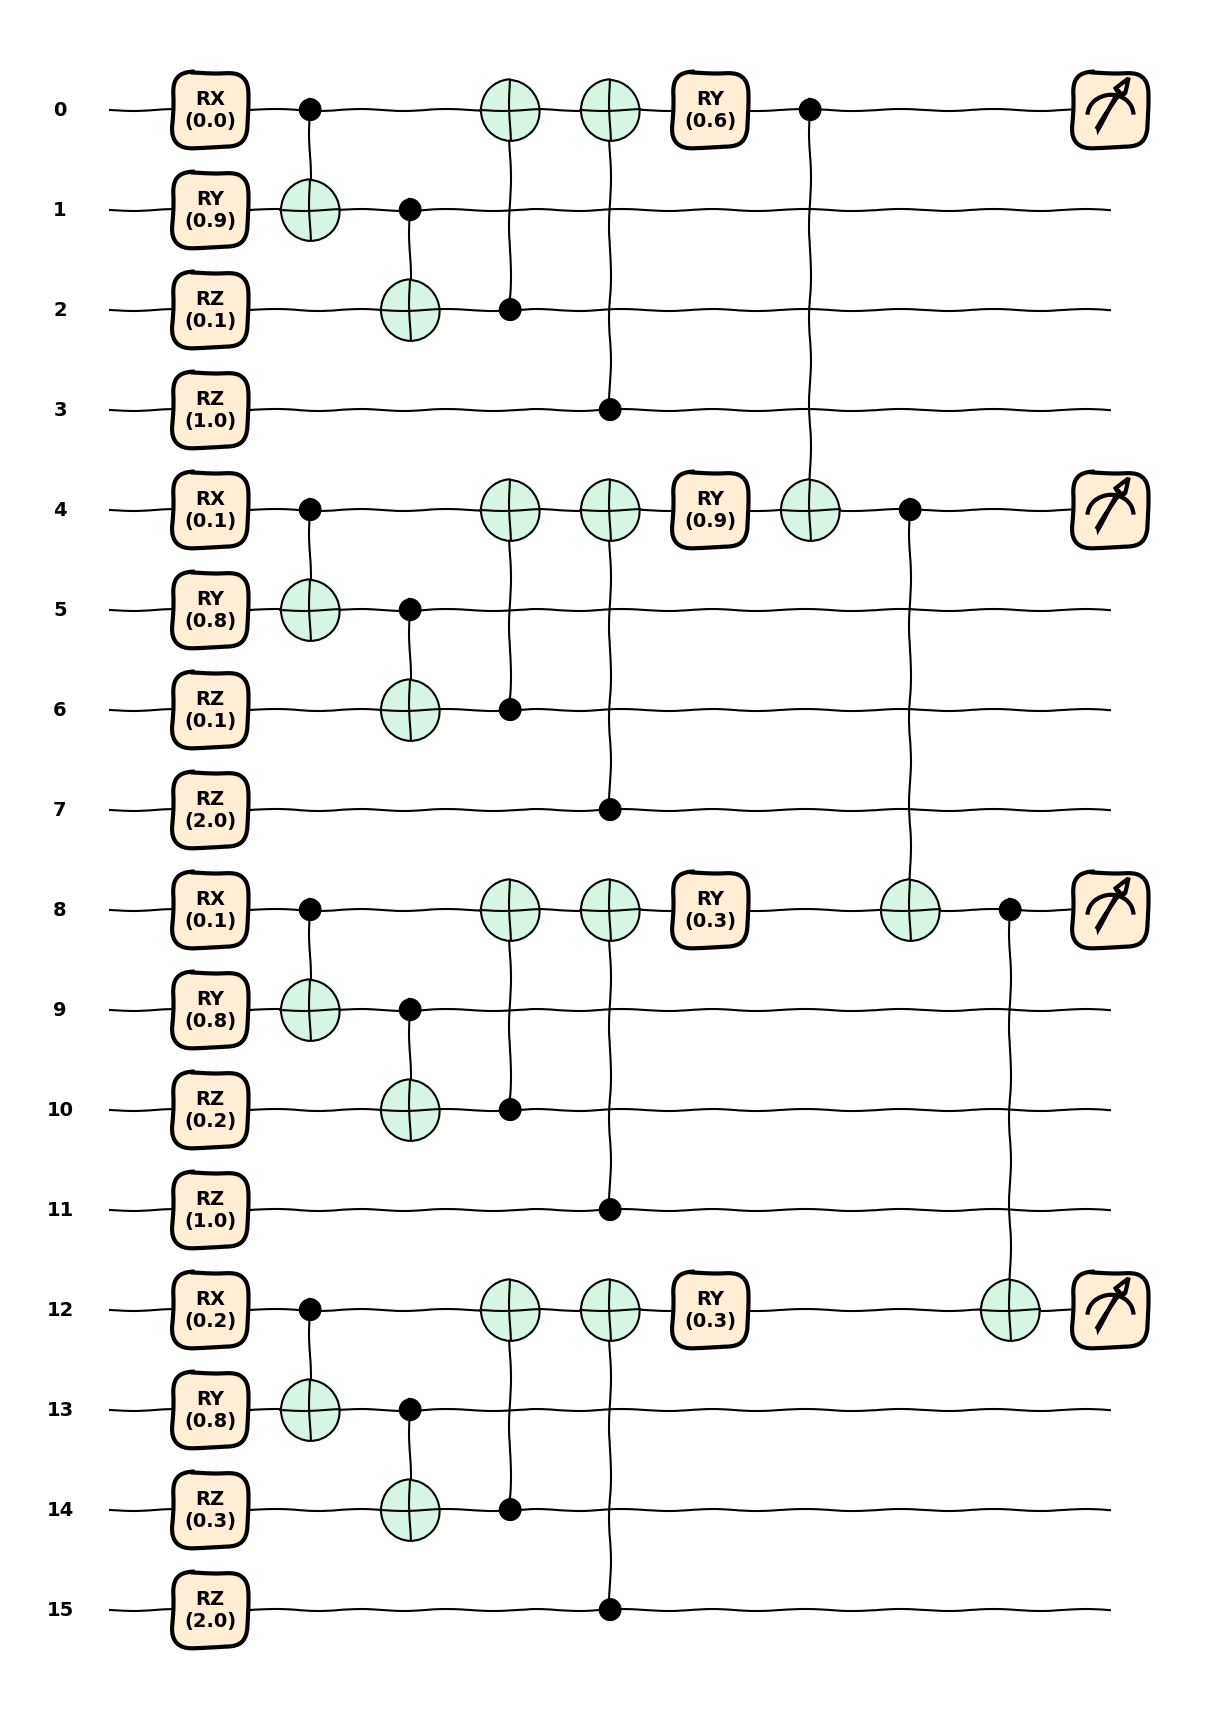

In [112]:
def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(4):
                if j==0:
                    qml.RX(X[i*4+j], wires = i * 4 + j)
                elif j==1:
                    qml.RY(X[i*4+j], wires = i * 4 + j)
                else:
                    qml.RZ(X[i*4+j], wires = i * 4 + j)
            #Entangle 3 positions
            qml.CNOT(wires = [i * 4, i * 4 + 1])
            qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
            qml.CNOT(wires = [i * 4 + 2, i * 4])
            #Entangle color and position-x.
            qml.CNOT(wires = [i * 4 + 3, i * 4])
            # Encode each feature value into a qubit 
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 4)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 4, j * 4])
        return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(Nv)),qml.sample(qml.PauliZ(2*Nv)),qml.sample(qml.PauliZ(3*Nv))

        #return [qml.expval(qml.PauliZ(i*4)) for i in range(Nv)]
dev = qml.device("default.qubit", wires=4*Nv)
qnode = qml.QNode(quantum_circuit, dev)
qml.draw_mpl(qnode, decimals=1, style="sketch")(Xs[0],ansatz)
plt.show()

In [113]:
# Initialize a measurement quantum circuit
def circuit(X, ansatz):
    dev = qml.device('default.qubit', wires=Nv*4, shots=100)
    @qml.qnode(dev)
    def quantum_circuit(X,ansatz):
        for i in range(Nv):
            for j in range(4):
                if j==0:
                    qml.RX(X[i*4+j], wires = i * 4 + j)
                elif j==1:
                    qml.RY(X[i*4+j], wires = i * 4 + j)
                else:
                    qml.RZ(X[i*4+j], wires = i * 4 + j)
        #Entangle 3 positions
        qml.CNOT(wires = [i * 4, i * 4 + 1])
        qml.CNOT(wires = [i * 4 + 1, i * 4 + 2])
        qml.CNOT(wires = [i * 4 + 2, i * 4])
        #Entangle color and position-x.
        qml.CNOT(wires = [i * 4 + 3, i * 4])
        # Apply trainable entanglement gates based on adjacency matrix A
        for i in range(len(A)):
            qml.RY(ansatz[i], wires = i * 4)
        for i in range(len(A)):
            for j in range(i + 1, len(A)):
                if A[i][j] == 1:
                    # Use trainable parameters for entanglement angles
                    qml.CNOT(wires = [i * 4, j * 4])
        return qml.sample(qml.PauliZ(0)),qml.sample(qml.PauliZ(Nv)),qml.sample(qml.PauliZ(2*Nv)),qml.sample(qml.PauliZ(3*Nv))
    x = quantum_circuit(X, ansatz)
    y = [[x[0][i], x[1][i], x[2][i], x[3][i]] for i in range(len(x[0]))]
    return y

In [114]:
#Measure with the fixed parameters
dev = qml.device('default.qubit', wires=Nv*4, shots=100)
@qml.qnode(dev)
def measure(X,ansatz):
    x = quantum_circuit(X, ansatz)
    #y = [[x[0][i], x[1][i], x[2][i], x[3][i]] for i in range(100)]
    #return y
    return x
def transform(x):
    y = [[x[0][i], x[1][i], x[2][i], x[3][i]] for i in range(100)]
    return y
def minus_to_zero(y):
    for j in range(len(y)):
        for i in range(4):
            if y[j][i]<0:
                y[j][i]=0
    return y
result=minus_to_zero(transform(measure(X,ansatz)))
result_f=minus_to_zero(transform(measure(X_f,ansatz)))

In [117]:
results=[]
for X in Xs:
    result=minus_to_zero(transform(measure(X,ansatz)))
    results.extend(result)
results_f=[]
for X_f in Xs_f:
    result=minus_to_zero(transform(measure(X_f,ansatz)))
    results_f.extend(result)

In [123]:
def plot_result(measurements,tf):
    # Convert each sublist in y to a binary string and create a list of binary strings
    binary_strings = [''.join(map(str, sublist)) for sublist in result]
    unique_binary_strings, counts = np.unique(binary_strings, return_counts=True)
    # Plotting the histogram
    plt.bar(unique_binary_strings, counts, edgecolor='black')
    # Adding labels and title
    plt.xlabel('Results')
    plt.ylabel('Frequency')
    if tf=='T':
        plt.title('4-qubits measurement for true 4-nodes graph')
    else:
        plt.title('4-qubits measurement for false 4-nodes graph')
    # Display the plot
    plt.show()

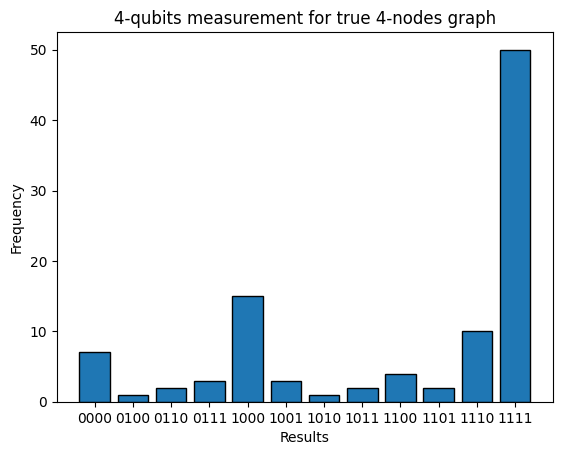

In [124]:
plot_result(results,'T')

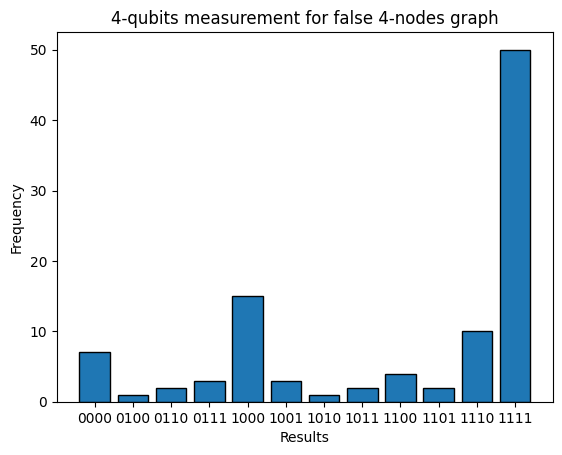

In [125]:
plot_result(results_f,'F')